# FuelProphet model

In [1]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date, time, timedelta

from sklearn.metrics import mean_squared_error,mean_absolute_error

import sys
import os
# Get the parent directory and add it to sys.path
parent_dir = os.path.abspath("..")
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from functions_nico.nico_fuelprophet import FuelProphet
from functions_nico.nico_preprocessing import load_data, merge_oil, merge_ex_rate, get_oil_euro
from functions_nico.nico_models import baseline_model, print_model, split_data,prophet_model

/Users/nicoschreiber/Desktop/Neue_Fische/Python/FuelProphet/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
df = load_data("../data/fueldata/wertheim_23-25.parquet") # Load fuel data
#df = merge_oil(df)                                        # Include oil data
#df = merge_ex_rate(df)                                    # Include exchange rates
#get_oil_euro(df)                                          # Calculate oil price in euro

# Reduce data
df = df[df["datetime"] >= pd.to_datetime("2025-04-01")]
df = df[df["station_uuid"] == "fb0f8030-c1eb-4df1-9410-054eea7422ad"]

In [3]:
# Initialization
b0 = np.array([0.15,0.08,0.06,0.04,0.02,0.55,0.1])
b0 = np.array([0.3,0.1,0.1,0.1,0.1,0.1,0.2])

# Split data
train,test = split_data(df,interval="2025-04-30")
train_array = np.array(train[["e5"]])[:,0]
test_array = np.array(test[["e5"]])[:,0]

In [4]:
# Setup model
model = FuelProphet(b0=b0,features=[-1,-2,-3,-4,-5,-288,-(7*288)])
model.normalize()
model.fit(train_array,test_array)
pred = model.predict(X=train_array,num_predictions=288)
print(model.b)

[0.3 0.1 0.1 0.1 0.1 0.1 0.2]


/Users/nicoschreiber/Desktop/Neue_Fische/Python/FuelProphet/functions_nico/nico_models.py:223: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


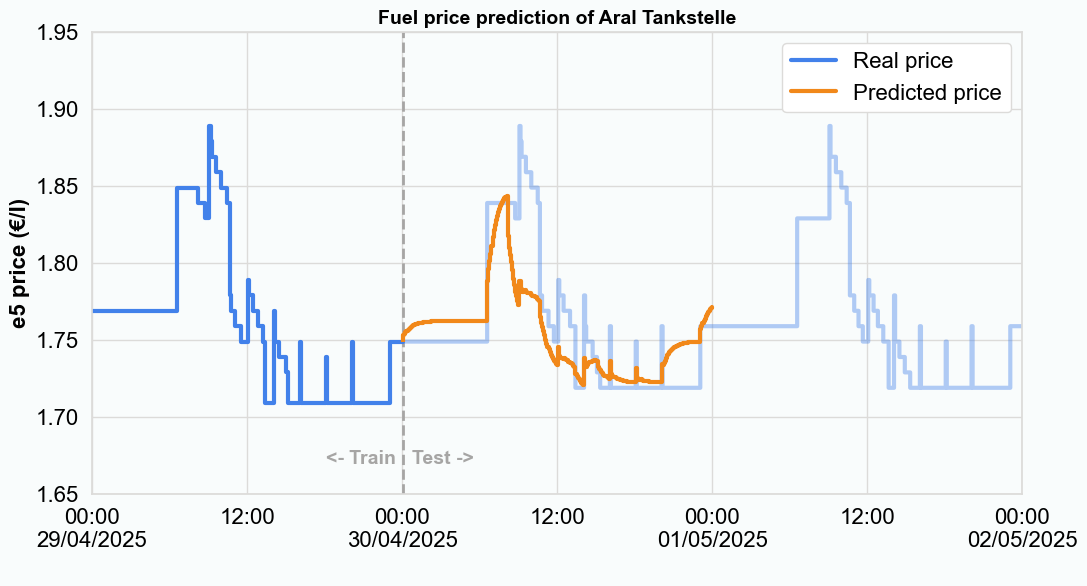

RMSE: 0.027
MAE: 0.019
R2: 0.605


In [5]:
# Plot
df_pred = pd.concat([pd.DataFrame(test[:288].datetime).reset_index(drop=True),
                     pd.DataFrame(pred, columns=["e5"]).reset_index(drop=True)],
                    axis=1)
df_pred.columns = ["datetime","e5"]

# Print model results
params = {"background":"#f9fcfc",
          "gridcolor": "#dcdbd9",
          "legendedge": "#dcdbd9",
          "legendface": "white",
          "legendcol": "black",
          "textcolor": "black"
          }

print_model(df,df_pred,xlim=("2025-04-29","2025-05-02"),ylim=(1.65,1.95),params=params)